In [1]:
%matplotlib inline 

import numpy as np
import math
import cv2
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output
import os, sys, random
import gym
from gym import spaces

from pathlib import Path
from tqdm import tqdm
import jdc

## helper functions

In [2]:
def load_image_mask(path, img_path, msk_path):
    """ Load image and mask (in final prototype will be received from previous step in pipeline)

    Parameters:
        path: relative path to folder with image and mask files
        img_path: image file name (with extension)
        msk_path: mask file name (with extension)

    Returns:
        image: image loaded
        mask: mask loaded
    """
    #print(os.path.join(path, img_path))
    image = cv2.imread(os.path.join(path, img_path))
    mask = cv2.cvtColor(cv2.imread(os.path.join(path, msk_path)), cv2.COLOR_BGR2GRAY)

    
    thrshd = 100  ### to delete artifacts
    mask[mask > thrshd] = 255
    mask[mask <= thrshd] = 0
    
     
    return image, mask

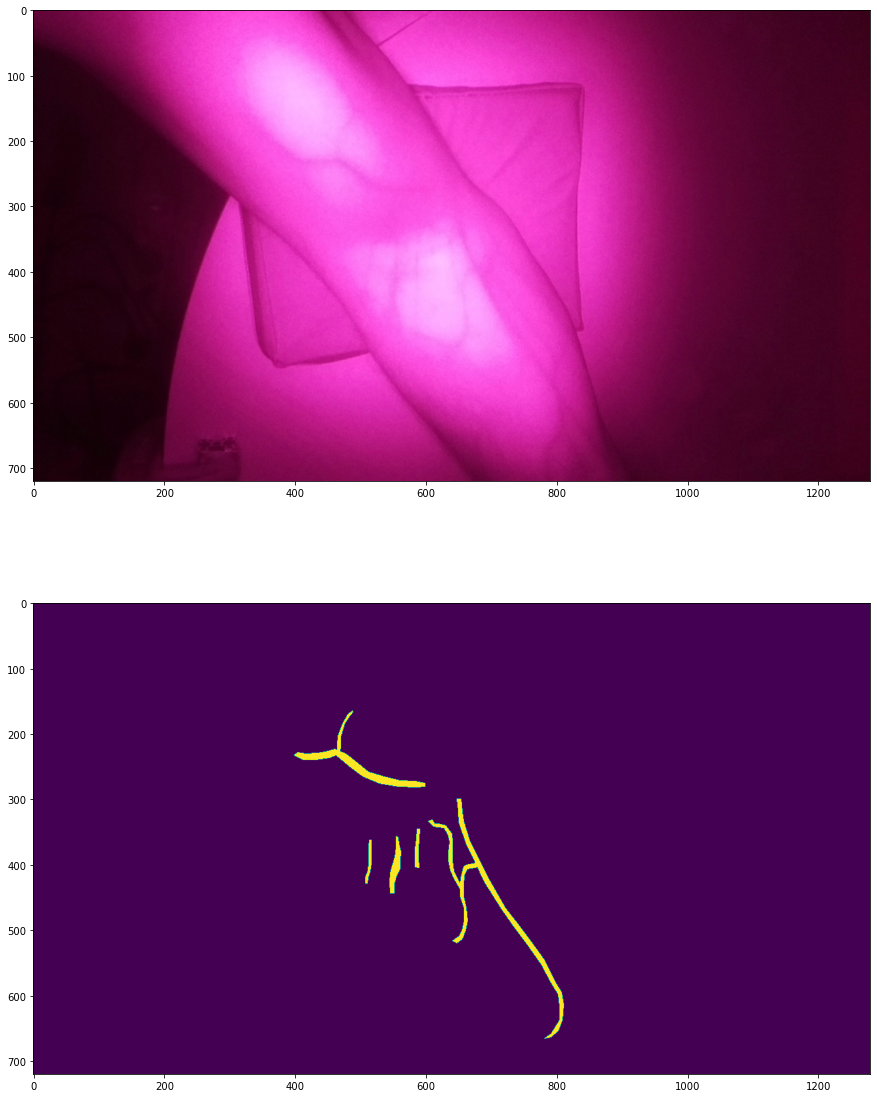

(720, 1280)


In [3]:
PREFIX = "./images/"

image="image.jpg"
mask="mask.jpg"


load_image, load_mask = load_image_mask(PREFIX, image, mask)

fig,(ax1, ax2) = plt.subplots(2, 1, figsize=(15, 20))
ax1.imshow(load_image)
ax2.imshow(load_mask)
plt.show() 
print(load_mask.shape)

# f = plt.figure() 
# f.set_figwidth(20) 
# f.set_figheight(20) 
# plt.imshow(load_mask)
# plt.show() 


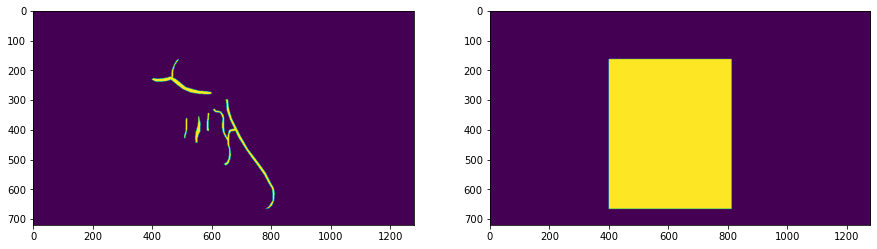

In [5]:
def mask_rectangle(mask):
    """ Given vein mask return a rectangle mask of the initial area

    Parameters:
        mask:     image (int n*m matrix). grayscale vein mask 
    Returns:
        rectangle:  image (int n*m matrix). grayscale rectangle mask
    """
    rectangle = mask.copy()
    rectangle.fill(0)
    vett_mask = np.array(np.nonzero(mask))
    roi_mask = [vett_mask[0].min(),vett_mask[0].max()+1, vett_mask[1].min(),vett_mask[1].max()+1]
    rectangle[roi_mask[0]:roi_mask[1], roi_mask[2]:roi_mask[3]] = 255 
    return rectangle 

rectangle = mask_rectangle(load_mask)
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(15, 40))
ax1.imshow(load_mask)
ax2.imshow(rectangle)
plt.show() 



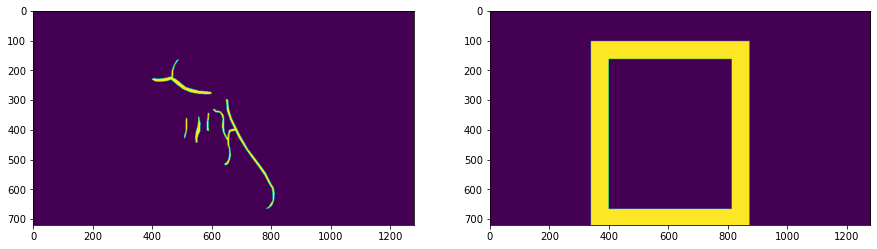

In [6]:
def mask_contour(mask):
    """ Given mask return an outline mask (rectangle mask contour with width: bord)

    Parameters:
        mask:     image (int n*m matrix).  vein mask 
    Returns:
        contour:  image (int n*m matrix). grayscale contour of vein mask
    """

    contour = mask.copy()
    vett = np.array(np.nonzero(contour))
    bord=60
    rows_up=[max(vett[0].min()-bord,0), vett[0].min()]
    rows_down=[vett[0].max()+1, min(vett[0].max()+bord+1,contour.shape[0])]
    cols_left=[max(vett[1].min()-bord,0), vett[1].min()]
    cols_right=[vett[1].max()+1, min(vett[1].max()+bord+1,contour.shape[1])]
    
    roi = [rows_up, rows_down, cols_left, cols_right]
    
    contour.fill(0)
    contour[rows_up[0]:rows_up[1], cols_left[0]:cols_right[1]] = 255
    contour[rows_down[0]:rows_down[1], cols_left[0]:cols_right[1]] = 255
    contour[rows_up[0]:rows_down[1], cols_left[0]:cols_left[1]] = 255
    contour[rows_up[0]:rows_down[1], cols_right[0]:cols_right[1]] = 255

    return contour


contour = mask_contour(load_mask)
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(15, 40))
ax1.imshow(load_mask)
ax2.imshow(contour)
plt.show() 


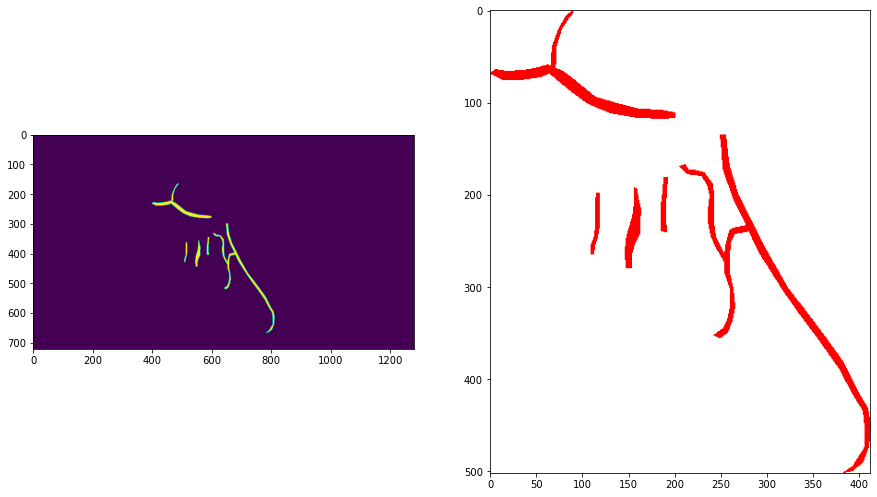

In [7]:
def mask_crop_colour(mask):
    """ Given mask return a projectable version of it cropping out the empty area outside the 
    minimum enclosing rectangle of the vein mask, switching veins to red & the empty area to white

    Parameters:
        mask:       image (int n*m matrix). grayscale vein mask 
    Returns:
        proj_mask:  image (int n*m*c matrix). vein mask suitable for projection
    """
    
    temp = mask.copy()
    vett = np.array(np.nonzero(temp))
    roi = [vett[0].min(),vett[0].max()+1, vett[1].min(),vett[1].max()+1]
    cut  = temp[roi[0]:roi[1], roi[2]:roi[3]]
    colored = np.zeros((cut.shape[0], cut.shape[1], 3), dtype=np.uint8)
    colored.fill(255)

    if(len(cut[:, :].shape)<3 or cut[:, :].shape[2]==1):
        colored[...,0] = 255-cut[:, :]
        colored[...,1] = 255-cut[:, :]
    else:
        colored[...,0] = 255-cut[:, :, 2]
        colored[...,1] = 255-cut[:, :, 2]
    
    return colored
    
#, rMin, cMin, rMax, cMax
colored = mask_crop_colour(load_mask)#, load_convex)
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(15, 40))
ax1.imshow(load_mask)
ax2.imshow(colored[..., ::-1])
plt.show()     

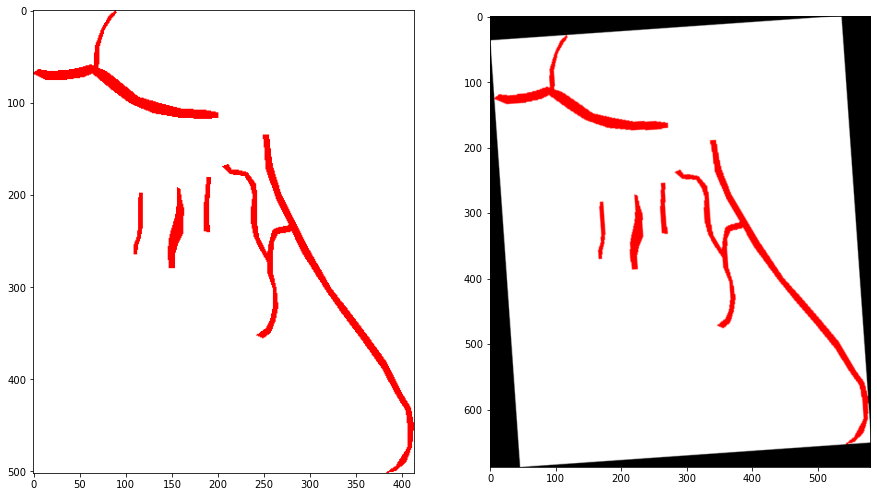

In [8]:
def rotate_scale(mask, angle=0, scale=1):
    """ Given colored mask, an angle and a scaling factor return the mask
    after the rotation and scaling, the new empty areas are set to black

    Parameters:
        mask:  image (int n*m*c matrix). colored vein mask suitable for projection
        angle: int. degrees of rotation (counterclockwise orientation)
        scale: float. scaling factor (e.g. 1.01 scale up 1%; 0.90 scale down to 90% of original size)
    Returns:
        rs_mask:  image (int n*m*c matrix). vein mask rotated and scaled
    """
    # grab the dimensions of the image and then determine the
    # center
    
    img = mask.copy()
    (h, w) = img.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    # grab the rotation matrix then grab the sine and cosine
    M = cv2.getRotationMatrix2D((cX, cY), angle, scale)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    # perform the actual rotation and return the image
    rs_mask = cv2.warpAffine(img, M, (nW, nH), borderValue=(0, 0, 0))
    
    #rs_mask[rs_mask > 0] = 255
    
    return  rs_mask 
rot = rotate_scale(colored, 4, 1.3)
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(15, 40))
ax1.imshow(colored[..., ::-1])
ax2.imshow(rot[..., ::-1])
plt.show()

In [9]:
def sim_projection(image, colored_mask, tr_rows, tr_cols, angle=0, scale=1.0):
    """ Given an image, a colored mask and transformation parameters merge the mask on the image 
    to simulate the physical projector. Return the merged image.

    Parameters:
        image:  image (int n*m*c matrix). image from camera 
        colored_mask: (int n*m*c matrix). colored vein mask suitable for projection
        tr_rows: int. vertical mask translation WRT the image   (start from top)
        tr_cols: int. horizontal mask translation WRT the image (start from left)
        angle: int. degrees of rotation (counterclockwise orientation)
        scale: float. scaling factor (e.g. 1.01 scale up 1%; 0.90 scale down to 90% of original size)
    Returns:
        merged:  image (int n*m*c matrix). vein mask rotated and scaled
    """
    #make copies of image and mask
    merged = image.copy()
    projection = colored_mask.copy()

    # sanity check for integers
    tr_rows = int(tr_rows)
    tr_cols = int(tr_cols)
    angle = int(angle)
    
    # apply rotation and scaling of mask
    rotated = rotate_scale(projection, angle, scale)
    
    # if in the previous step the mask was rotated the size overall size changed
    # need to recalculate the translation offsets WRT the new dimensions
    # delta_r is how much the height changed after rotate_scale() function. 
    # since it affect both the upper and lower part of the mask it's divided by 2
    # same for delta_c for witdh
    delta_r = int((rotated.shape[0]-colored_mask.shape[0])/2)
    delta_c = int((rotated.shape[1]-colored_mask.shape[1])/2)

    # sanity check in order to write over the original image 
    # avoid underflow (try to write on negative indexes)
    delta_r_min = np.abs(min(tr_rows - delta_r, 0))
    delta_c_min = np.abs(min(tr_cols - delta_c, 0))
    
    # sanity check in order to write over the original image 
    # avoid overflow (try to write on indexes bigger than the image size)    
    delta_r_max = np.abs(max(tr_rows -delta_r + rotated.shape[0] - merged.shape[0], 0))
    delta_c_max = np.abs(max(tr_cols -delta_c + rotated.shape[1] - merged.shape[1], 0))

    # 
    prj_crds=[tr_rows -delta_r + delta_r_min, tr_rows -delta_r + rotated.shape[0] - delta_r_max, tr_cols -delta_c + delta_c_min, tr_cols -delta_c + rotated.shape[1]-delta_c_max]

    img_overlap = cv2.addWeighted(merged[prj_crds[0]:prj_crds[1], prj_crds[2]:prj_crds[3]], 0.9, rotated[delta_r_min:rotated.shape[0]-delta_r_max, delta_c_min:rotated.shape[1]-delta_c_max], 0.7, 0)

    merged[prj_crds[0]:prj_crds[1], prj_crds[2]:prj_crds[3]] = img_overlap
    
    return merged 

In [10]:
def analyze_image_mask(image, mask, init_roi):
    """ Given image and mask calc the average intensity of the mask area

    Parameters:
        image: image (int n*m matrix). grayscale
        mask: image (int n*m matrix). grayscale

    Returns:
        intensity: int. average intensity of the mask area
    """
    img = image
    if len(image.shape)>2 and image.shape[2]==3:
        img = image[:,:,2]
       
    roi=img[mask>0]
    
    # explanation of the next line 
    # count the element of the mask that have an increased intensity value (greater than their value when the projector was off)
    # add the pixels that eventually where already maxed before the projection (their intensity was already 255 so there can not be an increment)
    # multiply by 1000 and divide by the number of pixels present in the mask, (this way the metric goes from 0 to 1000)
    return int(np.round(np.divide((np.greater(roi, init_roi).sum()+len(init_roi[init_roi==255]))*1000, len(roi))))

if len(load_image.shape)>2 and load_image.shape[2]==3:
    img = load_image[:,:,2]
    mask_roi = img[rectangle>0]
    contour_roi = img[contour>0]
else:
    mask_roi = load_image[rectangle>0]
    contour_roi = load_image[contour>0]

Mask roi len:207326
Contour roi len:121002
Mask width: 502, height: 413, area: 207326


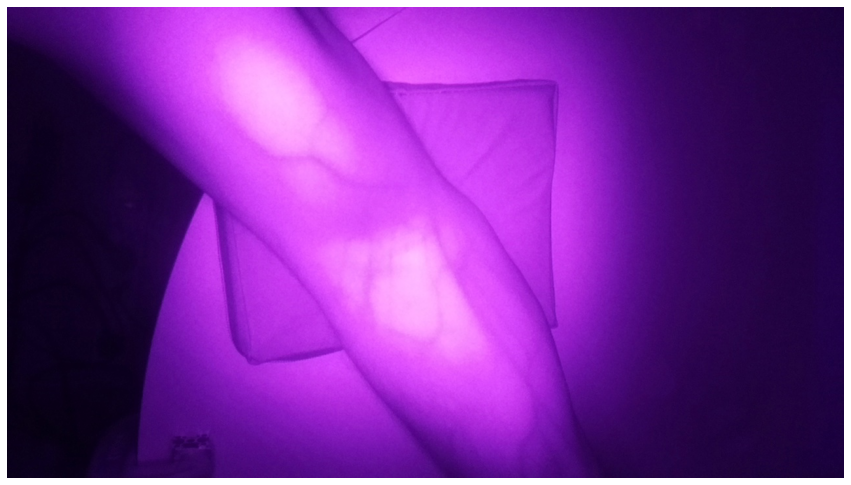

Initial mask area value: 25
Initial contour area value: 19


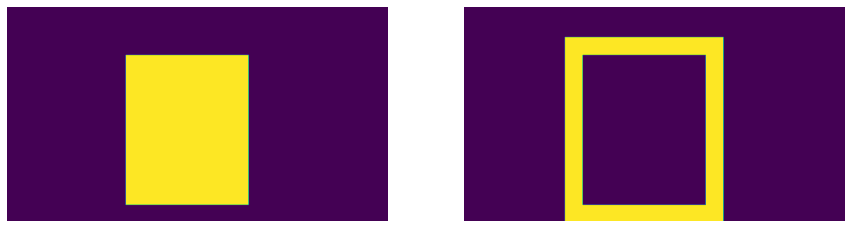

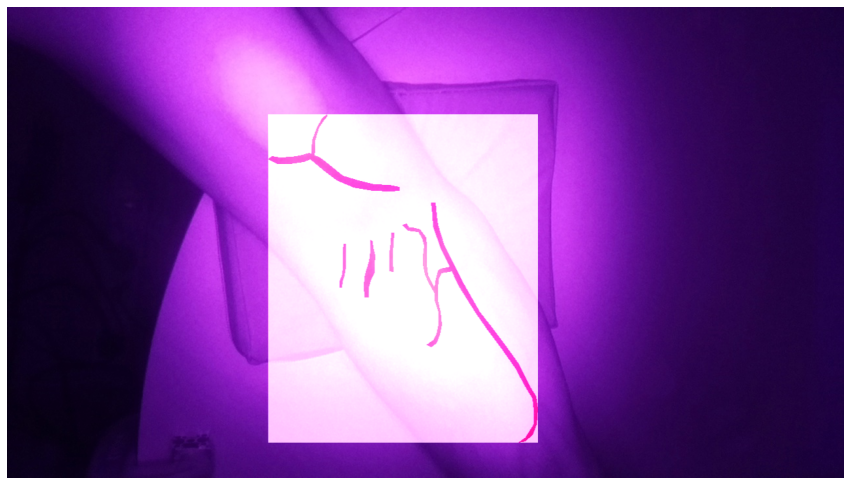

Mask area value: 1000
Contour area value: 19


In [11]:
print("Mask roi len:" + str(len(mask_roi)))
print("Contour roi len:" + str(len(contour_roi)))
    
print("Mask width: {}, height: {}, area: {}".format(colored.shape[0], colored.shape[1], colored.shape[0]*colored.shape[1]))    
    
fig,(ax1) = plt.subplots(1, figsize=(15, 15))
ax1.imshow(load_image[..., ::-1])
ax1.set_axis_off()
plt.show() 
print("Initial mask area value: " +str(analyze_image_mask(load_image, rectangle, mask_roi)))
print("Initial contour area value: " +str(analyze_image_mask(load_image, contour, contour_roi)))


fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(15, 40))
ax1.imshow(rectangle)
ax1.set_axis_off()
ax2.imshow(contour)
ax2.set_axis_off()
plt.show() 

ret = sim_projection(load_image, colored, 164,  399, 0, 1)
fig,(ax1) = plt.subplots(1, figsize=(15, 15))
ax1.imshow(ret[..., ::-1])
ax1.set_axis_off()
plt.show() 

print("Mask area value: " +str(analyze_image_mask(ret, rectangle, mask_roi)))
print("Contour area value: " +str(analyze_image_mask(ret, contour, contour_roi)))


In [12]:
def analyze_image(image, mask, contour, val_mask, val_contour):
    """ Given image, mask, mask_outline and init_value calc the "projection alignment" 
    as mean intensity in our ROI minus the increased intensity in the surrounding (contour) area 

    Parameters:
        image:         image (int n*m[*c] matrix). [grayscale] image from camera 
        mask:          image (int n*m matrix). grayscale vein mask 
        mask_contour:  image (int n*m matrix). grayscale contour of vein mask
        val_mask:      int. initial intensity value of the mask area
        val_outl:      int. initial intensity value of the mask_outline area
    Returns:
        align:      int. metric for alignment
    """
    
    img = image.copy()
    # if the image is 3 channel take only the RED (opencv order is BGR)
    if len(image.shape)>2 and image.shape[2]==3:
        img = image[:,:,2]

    roi_mask = img[mask>0] 
    roi_contour = img[contour>0]
    
    # explanation of the next line 
    # count the element of the mask that have an increased intensity value (greater than their value when the projector was off)
    # add the pixels that eventually where already maxed before the projection (their intensity was already 255 so there can not be an increment)
    # multiply by 1000 and divide by the number of pixels present in the mask, (this way the metric goes from 0 to 1000)
    metr_mask = int(np.round(np.divide((np.greater(roi_mask, val_mask).sum()+len(val_mask[val_mask==255]))*1000, len(roi_mask))))
    
    # same procedure but for the outline area around the mask
    # the only difference is that we do not add elements initially equal to 255, since there is
    # no way to affect those with the mask projection
    metr_contour = int(np.round(np.divide(np.greater(roi_contour, val_contour).sum()*1000, len(roi_contour))))
    
    # return metr_mask minus metr_outline (we want the projection over the mask and not over the surrounding area)
    return metr_mask-metr_contour

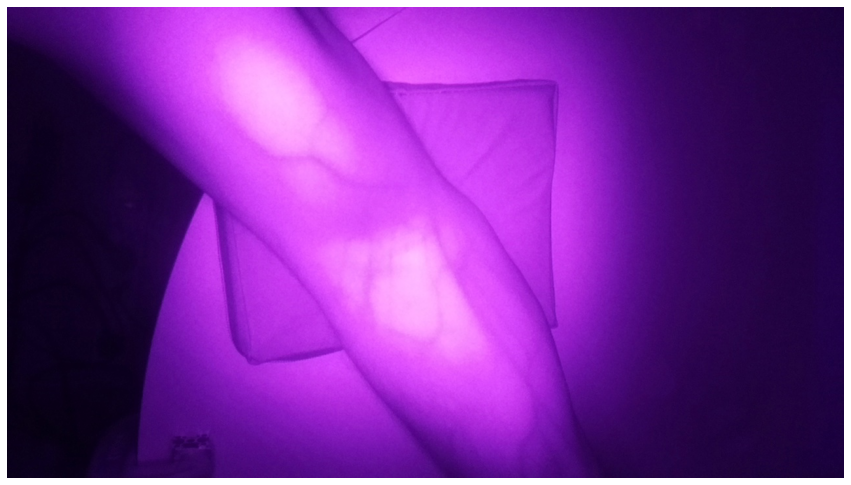

Initial mask area value: 25
Initial contour area value: 19
Initial metric value: 25


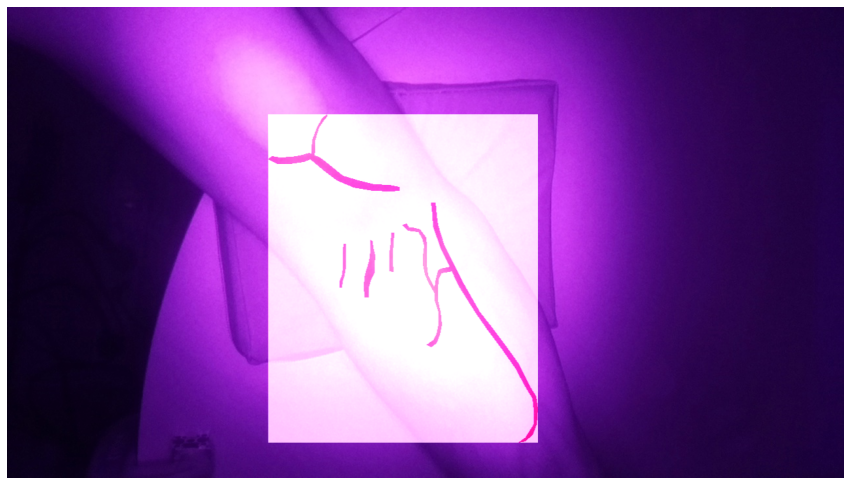

Mask area value: 1000
Contour area value: 19
Metric value: 1000


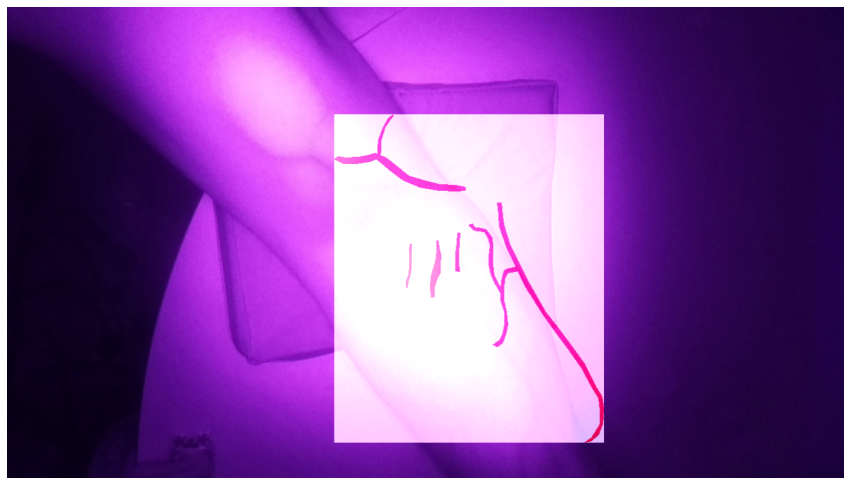

Mask area value: 760
Contour area value: 268
Metric value: 511


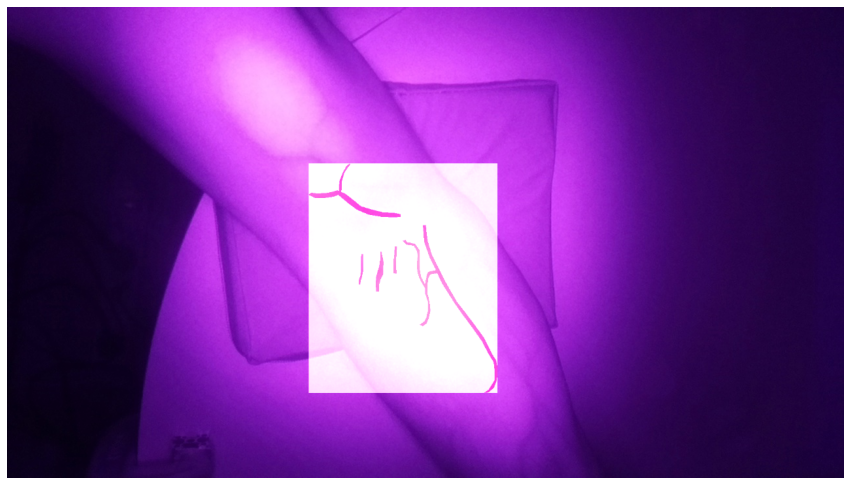

Mask area value: 494
Contour area value: 19
Metric value: 494


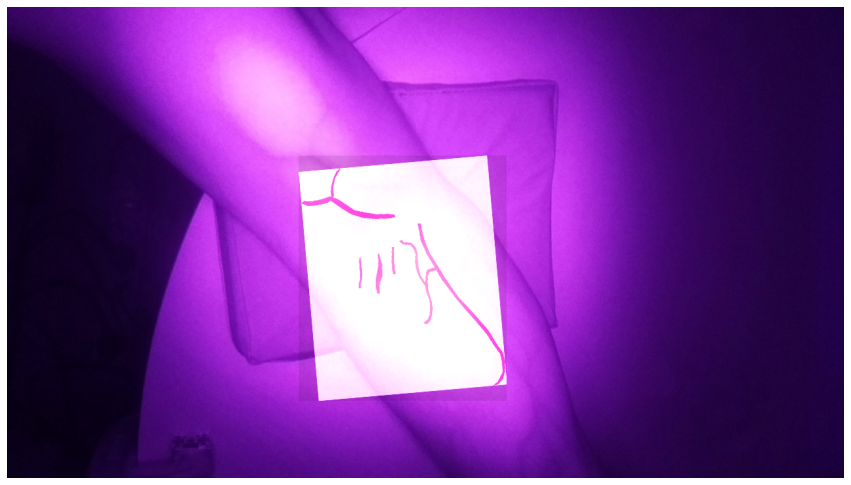

Mask area value: 496
Contour area value: 19
Metric value: 496


In [13]:
if len(load_image.shape)>2 and load_image.shape[2]==3:
    img = load_image[:,:,2]
    mask_roi = img[rectangle>0]
    contour_roi = img[contour>0]
else:
    mask_roi = load_image[rectangle>0]
    contour_roi = load_image[contour>0]
   
fig,(ax1) = plt.subplots(1, figsize=(15, 15))
ax1.imshow(load_image[..., ::-1])
ax1.set_axis_off()
plt.show() 
print("Initial mask area value: " +str(analyze_image_mask(load_image, rectangle, mask_roi)))
print("Initial contour area value: " +str(analyze_image_mask(load_image, contour, contour_roi)))
print("Initial metric value: " +str(analyze_image(load_image, rectangle, contour, mask_roi, contour_roi)))

ret = sim_projection(load_image, colored, 164,  399, 0, 1)
fig,(ax1) = plt.subplots(1, figsize=(15, 15))
ax1.imshow(ret[..., ::-1])
ax1.set_axis_off()
plt.show() 

print("Mask area value: " +str(analyze_image_mask(ret, rectangle, mask_roi)))
print("Contour area value: " +str(analyze_image_mask(ret, contour, contour_roi)))
print("Metric value: " +str(analyze_image(ret, rectangle, contour, mask_roi, contour_roi)))

ret = sim_projection(load_image, colored, 164,  500, 0, 1)
fig,(ax1) = plt.subplots(1, figsize=(15, 15))
ax1.imshow(ret[..., ::-1])
ax1.set_axis_off()
plt.show() 


print("Mask area value: " +str(analyze_image_mask(ret, rectangle, mask_roi)))
print("Contour area value: " +str(analyze_image_mask(ret, contour, contour_roi)))
print("Metric value: " +str(analyze_image(ret, rectangle, contour, mask_roi, contour_roi)))


ret = sim_projection(load_image, colored, 164,  399, 0, 0.7)
fig,(ax1) = plt.subplots(1, figsize=(15, 15))
ax1.imshow(ret[..., ::-1])
ax1.set_axis_off()
plt.show() 

print("Mask area value: " +str(analyze_image_mask(ret, rectangle, mask_roi)))
print("Contour area value: " +str(analyze_image_mask(ret, contour, contour_roi)))
print("Metric value: " +str(analyze_image(ret, rectangle, contour, mask_roi, contour_roi)))



ret = sim_projection(load_image, colored, 164,  399, 5, 0.7)
fig,(ax1) = plt.subplots(1, figsize=(15, 15))
ax1.imshow(ret[..., ::-1])
ax1.set_axis_off()
plt.show() 

print("Mask area value: " +str(analyze_image_mask(ret, rectangle, mask_roi)))
print("Contour area value: " +str(analyze_image_mask(ret, contour, contour_roi)))
print("Metric value: " +str(analyze_image(ret, rectangle, contour, mask_roi, contour_roi)))


# Custom Environment

In [14]:
class Mask_Proj_Env(gym.Env):
    """
    Custom Environment that follows gym interface.
    """
    # Define constants for clearer code
    STILL = 0       # no change
    UP    = 1       # up
    DOWN  = 2       # down
    LEFT  = 3       # left
    RIGHT = 4       # right
    CLOCKWISE = 5   # one degree clockwise rotation
    COUNTER = 6     # one degree counterclockwise rotation
    INCREASE = 7    # one percent increase
    DECREASE = 8    # one percent decrease
    nA = 9          # total number of possible actions
    
    
    action_names =  {0:"STILL", 1: "UP", 2: "DOWN", 3: "LEFT", 4: "RIGHT", 
                     5: "CLOCKWISE", 6: "COUNTER", 7: "INCREASE", 8: "DECREASE"}
    
    LIMIT=500
        
    def __init__(self, image, mask):
        super(Mask_Proj_Env, self).__init__()

        self.merge=None
        self.debug = False
        
        self.change_mask=False
        
        #image, vein_mask, convex_mask (maybe after create on the fly)
        self.image, self.vein_mask = image, mask
        # square mask
        self.mask = mask_rectangle(self.vein_mask)
        
        # colored image for projection
        self.mask_colour = mask_crop_colour(load_mask)
        
        # contour area (where to look for negative contribution)
        self.contour = mask_contour(self.vein_mask)   
    
    
        self.reward = None
     
            
        self.image_rows = self.image.shape[0]
        self.image_cols = self.image.shape[1]
    
        self.max_rot = 5
        self.nrot = self.max_rot*2 +1        
        
        self.max_scale = 0.1
        self.list_scale = np.round(np.arange(1-self.max_scale, 1+self.max_scale+0.01, 0.01), 2)
        self.nscale = len(self.list_scale)        
        
        
        coord = np.array(np.nonzero(self.vein_mask))

        #find target point in image
        self.target_row = coord[0].min() 
        self.target_col = coord[1].min() 
        self.target_rot = 0
        self.target_scale = int(self.nscale/2)        
        
        # Define action and observation space
        # They must be gym.spaces objects
        self.action_space = spaces.Discrete(self.nA)
        # The observation will be the coordinate of the agent
        self.low_state=np.array([-30000], dtype=np.int16)
        self.high_state=np.array([0], dtype=np.int16)
        self.observation_space = spaces.Box(low= self.low_state, high=self.high_state, dtype=np.int16)  
               
    def reset(self):

        self.merge = None
        self.done  = False
        self.count = 0
        self.change_mask = False
        
        """
        Important: the observation must be a numpy array
        :return: (np.array) 
        """
        max_delta_rows = self.mask_colour.shape[0]/4
        max_delta_cols = self.mask_colour.shape[1]/4 
 
        
        # agent relative positions start
        self.agent_row = np.random.randint(self.target_row-max_delta_rows, self.target_row+max_delta_rows)
        self.agent_col = np.random.randint(self.target_col-max_delta_cols, self.target_col+max_delta_cols) 
        self.agent_rot = random.randint(-self.max_rot, self.max_rot) 
        self.agent_scale = random.randint(0, self.nscale-1)       
       
    
        # vector with initial intensity values for the mask and contour area
        if len(self.image.shape)>2 and self.image.shape[2]==3:
            img = self.image[:,:,2]
            self.mask_roi = img[self.mask>0]
            self.contour_roi = img[self.contour>0]
        else:
            self.mask_roi = self.image[self.mask>0]
            self.contour_roi = self.image[self.contour>0]
                    
        if self.debug:
            print("Agent start position: {}, {}, {}, {}".format(self.agent_row, 
            self.agent_col, self.agent_rot, self.list_scale[self.agent_scale]))
        
        self.observation = self.calc_metric()
        return self.observation
  
    
    # image merging and align metric calc
    def calc_metric(self):
          
        self.merge = sim_projection(self.image, self.mask_colour, self.agent_row, self.agent_col, 
                                    self.agent_rot, self.list_scale[self.agent_scale])          
 
        metr = analyze_image(self.merge, self.mask, self.contour, self.mask_roi, self.contour_roi)
  
        if self.debug:
            print("Metric : {}".format(metr))

        # updated the metric precompiled table, later need to save
        self.update = True

        return metr


In [15]:
%%add_to Mask_Proj_Env

def step(self, action):
        err_msg = "%r (%s) invalid" % (action, type(action))
        assert self.action_space.contains(action), err_msg
                    
        done=False
        self.merge = None
        
        if action == self.UP:
            if self.agent_row > 0:
                self.agent_row -= 1
        elif action == self.DOWN:
            if self.agent_row < self.image_rows-1:
                self.agent_row += 1
        elif action == self.LEFT:
            if self.agent_col > 0:
                self.agent_col -= 1               
        elif action == self.RIGHT:
            if self.agent_col < self.image_cols-1:
                self.agent_col += 1   
        elif action == self.CLOCKWISE:
            if  self.agent_rot > -self.max_rot:
                 self.agent_rot -= 1               
        elif action == self.COUNTER:
            if  self.agent_rot < self.max_rot:
                 self.agent_rot += 1                   
        elif action == self.INCREASE:
            if self.agent_scale < len(self.list_scale)-1:
                 self.agent_scale += 1
        elif action == self.DECREASE:
            if self.agent_scale > 0:
                 self.agent_scale -= 1        
        elif action != self.STILL:
            raise ValueError("Received invalid action={} which is not part of the action space".format(action))

        """ simulate projection over video, if current combination of translation and rotation is not present 
        in the pre-calculated file do it and flag update to TRUE (will write the file when env is closed)
        """               
        reward = self.calc_metric()
        
        # if the metric is equal to 1000 the overlap is perfect
        # to make the env kind of sequential the agent should remain
        # perfectly aligned for self.LIMIT times
        if reward > 999:
            self.count+=1
            if self.count>self.LIMIT:
                done = True
        
        self.reward = reward
        
        
        return reward, done
    


In [16]:
%%add_to Mask_Proj_Env

def render(self):
    image = sim_projection(self.image, self.mask_colour, self.agent_row, self.agent_col, self.agent_rot, self.list_scale[self.agent_scale])#[..., ::-1]
    
    txt = 'row: ' + str(self.agent_row)
    
    cv2.putText(image, text= txt, org=(10,170),
            fontFace= cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.8, color=(0,255,0),
            thickness=2, lineType=cv2.LINE_AA)
    
    txt = "col: "  + str(self.agent_col) 
    
    cv2.putText(image, text= txt, org=(10,200),
            fontFace= cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.8, color=(0,255,0),
            thickness=2, lineType=cv2.LINE_AA)
    
    txt = "rot: " + str(self.agent_rot) 
    
    cv2.putText(image, text= txt, org=(10,230),
            fontFace= cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.8, color=(0,255,0),
            thickness=2, lineType=cv2.LINE_AA)
    
    txt = "scale: "  + str(self.list_scale[self.agent_scale])
    
    cv2.putText(image, text= txt, org=(10,260),
            fontFace= cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.8, color=(0,255,0),
            thickness=2, lineType=cv2.LINE_AA)    
    
    txt = "reward: "  + str(self.reward)
    
    cv2.putText(image, text= txt, org=(10,290),
            fontFace= cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.8, color=(0,255,0),
            thickness=2, lineType=cv2.LINE_AA)      
    
    return image

def close(self):
    # The array is saved in the file npfile.npy
    np.save(self.file, self.metric)
    pass

400


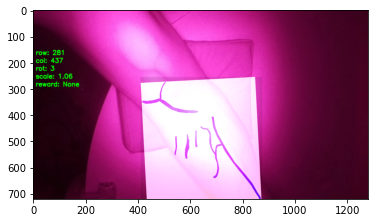

In [17]:
env = Mask_Proj_Env(load_image, load_mask)
print(env.reset())
plt.imshow(env.render())
plt.show()
#print(np.load('./metric_rectangle_translation.npy'))



# Start defining agent

In [18]:
class TabularSoftmaxWindowAgent(object):
    def __init__(self):
            self.rand_generator = None
            self.step_size = None
            self.prev_rew = None
            self.prev_true_obs = None
            self.still = None
            self.num_actions = None
            self.num_states = None
            self.q_path = ""
            self.actions = [0, 1, 2]
            self.debug = False
            self.change_mask = False
            
            
    def agent_init(self, agent_info={}):
        """Setup for the agent called when the experiment first starts.
        
        Args:
        agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
        {
            num_states (int): The number of states
            num_actions (int): The number of actions
            step_size (float): The step-size
            still (int): number representing the no-op action
            seed (int): optional seed for random number generation
            path (string): optional, path to saved model
            debug (bool): optional, flag for debugging prints
        }
        
        """
        # Store the parameters provided in agent_init_info.   
        
        if "debug" in agent_info:
            self.debug = agent_info["debug"]
        else:
            self.debug = False
        self.num_actions = agent_info["num_actions"]
        self.num_states = agent_info["num_states"]
        self.step_size = agent_info["step_size"]
        self.still = agent_info["still"]
        if "seed" in agent_info:
            self.rand_generator = np.random.RandomState(agent_info["seed"])
        else:
            self.rand_generator = np.random.RandomState()

        # Create an array for action-value estimates and initialize it to zero.
        if "path" in agent_info:
            self.q_path = agent_info["path"]
        if os.path.isfile(self.q_path):
            self.q = np.load(self.q_path)
        else:
            self.q = np.zeros((self.num_states, len(self.actions), self.num_states, len(self.actions), self.num_states, len(self.actions)), dtype='float32') # The array of action-value estimates.
            self.q[..., 1:] = 5
                    
        #self.counter = 0
        self.change_mask = False

        #self.calls.append("agent_init")

In [19]:
agent = TabularSoftmaxWindowAgent()
agent_info = {"num_actions": 9, "num_states": 4, "epsilon": 0.1, "step_size": 0.5, "discount": 0.9, "still": 0, "seed": 1, "path": ""}
agent.agent_init(agent_info)
print(agent.q[0,0,0,0,0,])
print(agent.q.shape)
print(type(agent.q[0,0,0,0,0,0,]))

[0. 5. 5.]
(4, 3, 4, 3, 4, 3)
<class 'numpy.float32'>


In [20]:
%%add_to TabularSoftmaxWindowAgent

def agent_policy(self, state_action):
    """ policy of the agent
    Args:
        state_action (Numpy array): active tiles returned by tile coder

    Returns:
        The action selected according to the policy
    """
    #print(state_action)
    
    # compute softmax probability
    c = np.max(state_action)
        
    # Compute the numerator by subtracting c from state-action preferences and exponentiating it
    numerator = np.exp(state_action - c)
    
    # Next compute the denominator by summing the values in the numerator (use np.sum)
    denominator = numerator.sum()
         
    # Create a probability array by dividing each element in numerator array by denominator
    softmax_prob = np.array([numerator[a]/denominator for a in range(len(numerator))])
    
    #print(softmax_prob)
    
    # Sample action from the softmax probability array
    chosen_action = self.rand_generator.choice(len(self.actions), p=softmax_prob)

    return chosen_action

In [21]:
agent = TabularSoftmaxWindowAgent()
agent_info = {"num_actions": 7, "num_states": 4, "epsilon": 0.1, "step_size": 0.5, "discount": 0.9, "still": 0, "seed": 1, "path": ""}
agent.agent_init(agent_info)
print(agent.q[0,0,0,0,0])
# compute softmax probability
counts=[0,0,0]
for i in range(10000):
    action = agent.agent_policy(agent.q[0,0,0,0,0]) 
    #print('Action: {}'.format(action))
    counts[action]+=1
print(counts)

[0. 5. 5.]
[35, 4970, 4995]


In [22]:
%%add_to TabularSoftmaxWindowAgent

def process_observation(self, observation):
    """Helper function called for translate the observation received into a smaller set of
    values used for state representation and reward
    Args:
        observation (int): the state observation from the environment (range [-255, 0]).
    Returns:
        reward (int): step reward (range [-3, 0]).
        adj_obs (int): tiled observation space (range [0, 3]). Used to index the elements of the Q_tensor
    """

    """ If this function is called in agent_start there is not yet a previous observation
    so here we set it as current one"""
    #print("process_observation self.prev_true_obs: " + str(self.prev_true_obs))
    if self.prev_true_obs == None:
        self.prev_true_obs = observation
        
    #print("process_observation prev_obs: {}".format(self.prev_true_obs))
        
    """- If the observation received is >=0 it means the agent is in the correct position, thus 0 reward
    - If the observation received is > than the previous it means the agent moved towards the 
    correct position, we want to assign a negative reward to minimize the # of step taken
    - If the observation received is = to the previous it means the agent made a useless  move, 
    we want to discourage it
    - If the observation received is < than the previous it means the agent moved away from the direction
    leading to the correct position, worste value assigned""" 
    #print(observation, self.prev_true_obs)
    if observation >= 1000:
        reward = 2  
        adj_obs = 3
    elif observation > self.prev_true_obs:
        reward = 1
        adj_obs = 2
    elif observation == self.prev_true_obs:
        reward = 0
        adj_obs = 1
    else:        
        reward = -2
        adj_obs = 0
 
    self.prev_true_obs = observation
        
    return reward, adj_obs

obs_strings={0: "Bad", 1: "Same", 2: "Good", 3: "Best"}

In [23]:
agent_info = {"num_actions": 5, "num_states": 4, "epsilon": 0.1, "step_size": 0.5, "discount": 0.9, "still": 0, "path": ""}

agent = TabularSoftmaxWindowAgent()
agent.agent_init(agent_info)
print("First: {}".format(agent.process_observation(200)))
print("Best: {}".format(agent.process_observation(1000)))
print("Bad: {}".format(agent.process_observation(900)))  
print("Same: {}".format(agent.process_observation(900)))
rew , obs =agent.process_observation(950)
print("Good: " + str([rew, obs]))
rew , obs =agent.process_observation(950)
print("Same? :" +  obs_strings[obs])

First: (0, 1)
Best: (2, 3)
Bad: (-2, 0)
Same: (0, 1)
Good: [1, 2]
Same? :Same


## Agent start

In [24]:
%%add_to TabularSoftmaxWindowAgent

def agent_start(self, observation):
    """The first method called when the episode starts, called after
    the environment starts.
    Args:
        obs (int): the state observation from the environment's evn_start function.
    Returns:
        action (int): the first action the agent takes.
    """
    self.actions = [0, 1, 2]
    reward, obs = self.process_observation(observation)
    if self.debug:
        print("start Reward: {}; Obs: {}, Observation: {}".format(reward, obs_strings[obs], observation))

    #print(self.q.shape)
    """Select first action from fake history of [obs, action_still, obs :] 
    the agent "think" that he didn't move and received the same reward"""
    current_q = self.q[obs, self.still, obs, self.still, obs]
#     print("[obs, self.still, obs]" + str([obs, self.still, obs, self.still, obs]))
#     print("current_q: " + str(current_q))
    
    # action selection via Softmax
    action = self.agent_policy(current_q)

    self.prev_state = [obs, self.still, obs, self.still, obs, self.still]
#     print("[obs, self.still, obs, self.still, obs], action" + str([obs, self.still, obs, action, obs, self.still,]))
#     print("self.prev_state: " + str(self.prev_state))
    
    self.prev_rew = reward
    self.prev_true_obs = observation
    
    if self.debug:
        print("Previous reward: {}".format(self.prev_rew))
    #self.calls.append("agent_start")
    
    
    #self.counter = 0
    return self.actions[action]


In [25]:
agent = TabularSoftmaxWindowAgent()
agent_info = {"debug": True, "num_actions": 7, "num_states": 4, "epsilon": 0.1, "step_size": 0.5, "discount": 0.9, "still": 0, "seed": 1, "path": ""}

agent.agent_init(agent_info)
action = agent.agent_start(-100)
print(action)
print("Action: {}".format(env.action_names[action]))
print("Prev: {}".format(agent.prev_state))

start Reward: 0; Obs: Same, Observation: -100
Previous reward: 0
1
Action: UP
Prev: [1, 0, 1, 0, 1, 0]


## Agent step

In [26]:
%%add_to TabularSoftmaxWindowAgent

def agent_step(self, observation):
    """A step taken by the agent.
    Args:
        observation (int): the state observation from the
            environment's step based on where the agent ended up after the
            last step.
    Returns:
        action (int): the action the agent is taking.
    """
    
    reward, obs = self.process_observation(observation)    
    
    if self.debug:
        print("Step Reward: {}; Obs: {}, Observation: {}".format(reward, obs_strings[obs], observation))
    

    t_obs, t_act, s_obs, s_act, f_obs, f_act = self.prev_state
    prev = self.q[t_obs, t_act, s_obs, s_act, f_obs]
     
    
    current_q = self.q[s_obs, s_act, f_obs, f_act, obs]
    
    if self.debug:
        print("prev_state indexes: {}" + str([obs_strings[t_obs], t_act, obs_strings[s_obs], 
                                              s_act, obs_strings[f_obs], f_act]))        
        print("prev_state: {}".format(prev))
        print("current_state indexes: {}" + str([obs_strings[s_obs], s_act, obs_strings[f_obs], 
              f_act, obs]))                
        print("current_q: {}".format(current_q))

   
    # Perform an update
    # --------------------------
    delta = self.step_size * reward
    if self.debug:
        print("Delta: {}".format(delta))
        
    # ob0, act0 | ob1, act1 | ob2, act2
    
    
    
    # first case, local maxima single state
    # 2 good observations with one bad in between: ob0 and ob2 = GOOD, ob1 = NO GOOD
    # the last 2 actions done are different, the agent backtracked: act1 not act2, eg -> and <-
    # act1 not Still to ensure that it moved away from the local maxima
    # change set of actions
    if s_obs==2  and obs==2 and f_obs<1  and s_act != f_act and s_act != self.still and f_act != self.still:
        if self.debug:
            print("Local maxima")
        if self.actions[-1]<self.num_actions-1:
            if self.debug:
                print("increase actions by 2")
                print("Pre: " + str(self.actions))
            self.actions[1:] = [x+2 for x in self.actions[1:]]
            if self.debug:
                print("Post: " + str(self.actions))
        else:
            self.actions[1:] = [1, 2]
            if self.debug:
                print("reset actions to 1, 2")            
                print("Post: " + str(self.actions))

        current_q = self.q[1, self.still, 1, self.still, obs]
        
    # second case, local maxima with multiple states
    # last observation is same as previous
    # the last 2 actions done are the same and not still, the agent 
    # moved towards a direction: act1 == act2, eg -> and ->
    # it means that the agent reached a maxima plateux 
    # change set of actions    
    elif obs ==1 and f_act != self.still and s_act == f_act:    
        if self.debug:
            print("Local maxima with multiple states")
        if self.actions[-1]<self.num_actions-1:
            if self.debug:
                print("increase actions by 2")
                print("Pre: " + str(self.actions))
            self.actions[1:] = [x+2 for x in self.actions[1:]]
            if self.debug:
                print("Post: " + str(self.actions))
        else:
            self.actions[1:] = [1, 2]
            if self.debug:
                print("reset actions to 1, 2")            
                print("Post: " + str(self.actions))
                
        current_q = self.q[1, self.still, 1, self.still, obs]
        #print("fine case 4")
           
        
    # all the other cases are covered by greedy RL
#    else:        
    if self.debug:
        print("Remaining cases, std greedy rl")
    prev[f_act] += delta
    #self.counter +=1
        
        
        
    # action selection via Softmax
    action = self.agent_policy(current_q)

    if self.debug:
        print("Updated previous Q: {}".format(prev))
    # --------------------------
    #self.calls.append("agent_step")
        


    self.prev_state =  np.append([s_obs, s_act, f_obs, f_act, obs], action)
    self.prev_rew = reward
    self.prev_true_obs = observation  
    return self.actions[action]


In [27]:
agent_info = {"debug": False, "num_actions": 5, "num_states": 4, "epsilon": 0.1, "step_size": 0.5, "discount": 0.9, "still": 0, "path": ""}

agent = TabularSoftmaxWindowAgent()
agent.agent_init(agent_info)
print("Initial Action: {}".format(env.action_names[agent.agent_start(-1500)]))
print("Prev: {}".format(agent.prev_state))
action = agent.agent_step(-1300)
print("First Step Action: {}".format(env.action_names[action]))
print("Prev: {}".format(agent.prev_state))
action = agent.agent_step(-1400)
print("Second Step Action: {}".format(env.action_names[action]))
print("Prev: {}".format(agent.prev_state))
action = agent.agent_step(0)
print("Third Step Action: {}".format(env.action_names[action]))
print("Prev: {}".format(agent.prev_state))

Initial Action: UP
Prev: [1, 0, 1, 0, 1, 0]
First Step Action: DOWN
Prev: [1 0 1 0 2 2]
Second Step Action: UP
Prev: [1 0 2 2 0 1]
Third Step Action: LEFT
Prev: [2 2 0 1 2 1]


## Agent end

In [28]:
%%add_to TabularSoftmaxWindowAgent

def agent_end(self, reward, old_reward):
    """Run when the agent terminates.
    Args:
        observation (int): observation (int): the state observation from 
        the environment's step when the agent enter the terminal state.
    """ 
    
    # save agent model
    if len(self.q_path)>0 and reward>old_reward:
        np.save(self.q_path, self.q)
        
    #self.calls.append("agent_end")   

In [29]:
agent_info = {"num_actions": 5, "num_states": 4, "epsilon": 0.1, "step_size": 0.5, "discount": 0.9, "still": 0, "path": ""}
agent = TabularSoftmaxWindowAgent()
agent.agent_init(agent_info)
print("Initial Action: {}".format(agent.agent_start(-150)))
print("Prev: {}".format(agent.prev_state))
print("\n")

action = agent.agent_step(-130)
print("First Step Action: {}".format(action))
print("Prev: {}".format(agent.prev_state))
print("\n")

agent.agent_end(-20, -np.Infinity)

Initial Action: 1
Prev: [1, 0, 1, 0, 1, 0]


First Step Action: 1
Prev: [1 0 1 0 2 1]




In [36]:
# Try to make the agent learn for 200 episodes

all_reward_sum = []
steps = []
q_file = "q_table.npy"
env = Mask_Proj_Env(load_image, load_mask)
agent_info = {"num_actions": env.nA, "num_states": 4, "step_size": 0.1, "still": 0, "path": q_file, "debug": False}
num_episodes = 10 # The number of episodes in each run

# max total numbers of steps per episode
n_steps=200


agent = TabularSoftmaxWindowAgent()
total=[]
old_ep_rew = -10000
best_reward = -10000
agent.agent_init(agent_info)
change=False

#ciclo su episodi
for episode in tqdm(range(num_episodes)):
    ep_rew = 0
    done = False
    # Runs an episode
    old_rew = env.reset()

    action = agent.agent_start(old_rew)

    for step in range(n_steps):
        #print("Action: {}".format(env.action_names[action]))

        reward, done = env.step(action)
        ep_rew+=reward        
        if done:
            print(ep_rew)
            old_ep_rew=ep_rew
            break
        action = agent.agent_step(reward) 

    total.append(ep_rew)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.12s/it]


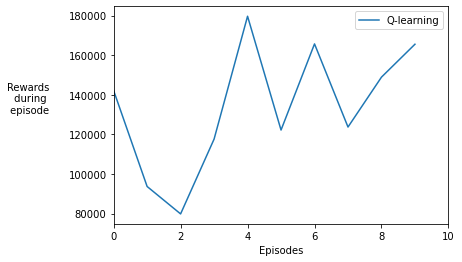

In [37]:
# plot results
plt.plot(total, label="Q-learning")
plt.xlabel("Episodes")
plt.ylabel("Rewards\n during\n episode",rotation=0, labelpad=40)
plt.xlim(0,len(total))
plt.legend()
plt.show()

In [ ]:
# RUN THIS CODE FOR A GIF FILE

import imageio

agent_info = {"num_actions": env.nA, "num_states": 4, "step_size": 0.1, "still": 0, "path": q_file}
#agent = TabularSoftmaxWindowAgent()
#agent.agent_init(agent_info)
agent.debug=False
single_run=[]
rews=[]
scales=[]
#agent.agent_init(agent_info, True)
change=False
images = []
done = False

# Runs an episode
rew = env.reset()  
rews.append(rew)
img = env.render()
images.append(img)
action = agent.agent_start(rew)


for step in tqdm(range(int(2000))):
    #print("Action: {}".format(env.action_names[action]))

    reward, done, info = env.step(action)
    rews.append(reward)
    img = env.render()
    images.append(img)
    scales.append(info["Scale_Agent"])
    
    if done:
        break
    action = agent.agent_step(reward) 
    

total.append(ep_rew)        
        
        
imageio.mimsave('test.gif', images[:], fps=30)

